In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob, pathlib
from zipfile import ZipFile
from datetime import datetime as dt
import re
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
def convert_unit(dataframe):
    dataframe['timestamp'] = dataframe['timestamp'].apply(lambda x: dt.fromtimestamp(x))
    return dataframe

def select_timestamp(dataframe, start_time, stop_time):
    start_day, stop_day = start_time.date(), stop_time.date()
    a = np.where(dataframe.columns.str.contains(r'^timestamp$'))[0]
    timestamp_col = dataframe.columns[a].to_list()[0]
    
    if start_day == stop_day:
        df = dataframe[(dataframe[timestamp_col] >= start_time) & (dataframe[timestamp_col] <= stop_time)]
    elif start_day != stop_day:
        df = dataframe[(dataframe[timestamp_col] >= start_time) & (dataframe[timestamp_col] <= stop_time)]
    return df

def plot_energy(df, start_day = '2022-01-28 0:00:00', stop_day = '2022-02-09 9:00:00'):
    # Select the day that to export into csv
    filtered_energy_df = df[(df['timestamp'] >= start_day) & (df['timestamp'] <= stop_day)].reset_index()

    ############# Create list of tick ##############
    timestamp = filtered_energy_df['timestamp'].dt.strftime('%d-%b-%Y %H:%M').to_numpy()
    timestamp_tick = [int(i-1) for i in np.linspace(1, timestamp.shape[0], 18)]
    timestamp_label = [timestamp[i] for i in timestamp_tick]
    print(timestamp_tick)
    ################################################

    plt.figure(1, [30,10])
    plt.plot(filtered_energy_df['power'], 'r')
    plt.xticks(ticks=timestamp_tick, labels=timestamp_label, rotation=30, fontsize=20)
    plt.grid(axis='x')
    plt.twinx()
    plt.plot(filtered_energy_df['energy'])

def plot_sensor(df, start_day = '2022-01-28 0:00:00', stop_day = '2022-02-09 9:00:00'):
    # Select the day that to export into csv
    filtered_energy_df = df[(df['timestamp'] >= start_day) & (df['timestamp'] <= stop_day)].reset_index()

    ############# Create list of tick ##############
    timestamp = filtered_energy_df['timestamp'].dt.strftime('%d-%b-%Y %H:%M').to_numpy()
    timestamp_tick = [int(i-1) for i in np.linspace(1, timestamp.shape[0], 18)]
    timestamp_label = [timestamp[i] for i in timestamp_tick]
    print(timestamp_tick)
    ################################################

    plt.figure(1, [30,10])
    plt.plot(filtered_energy_df['temperature'], 'r')
    plt.xticks(ticks=timestamp_tick, labels=timestamp_label, rotation=30, fontsize=20)
    plt.grid(axis='x')
    plt.twinx()
    plt.plot(filtered_energy_df['humidity'])

def remove_outlier(df_sensor):
    # Finding z-score of each point
    z_temp = abs(stats.zscore(df_sensor['temperature']))
    z_humid = abs(stats.zscore(df_sensor['humidity']))

    a_std = np.std(df_sensor['temperature'])
    
    print(f'Z-score of temperature data{np.where(z_temp > 2)}')
    print(f'Z-score of humidity data{np.where(z_temp > 2)}')
    a = df_sensor.iloc[np.where(z_temp > 2)]

    index_list = a.index
    for i in index_list:
        # Replace with previous value
        df_sensor['temperature'].iloc[i] = df_sensor['temperature'].iloc[i-1]
        df_sensor['humidity'].iloc[i] = df_sensor['humidity'].iloc[i-1]

    return df_sensor


def extract_user(user):
    current_user_path = all_user[all_user['User'] == user]
    current_user_path = current_user_path['file path'].sort_values(ascending=True).to_list()

    energy_user_path = [user_path for user_path in current_user_path if re.search(r'(energy|sensor)', user_path.split('/')[-1]).group() == 'energy']
    sensor_user_path = [user_path for user_path in current_user_path if re.search(r'(energy|sensor)', user_path.split('/')[-1]).group() == 'sensor']

    energy_df = pd.DataFrame()
    for i in range(0,len(energy_user_path)-1,2):
        df1 = pd.read_csv(energy_user_path[i], delimiter=',')
        df2 = pd.read_csv(energy_user_path[i+1], delimiter=',')
        energy_df = energy_df.append(pd.concat([df1,df2], axis=0))

    energy_df = convert_unit(energy_df.reset_index()).drop(columns='index')
    energy_df = energy_df.sort_values('timestamp', ascending=True).reset_index().drop(columns='index')

    sensor_df = pd.DataFrame()
    for i in range(0, len(sensor_user_path)-1,2):
        df1 = pd.read_csv(sensor_user_path[i], delimiter=',')
        df2 = pd.read_csv(sensor_user_path[i+1], delimiter=',')
        sensor_df = sensor_df.append(pd.concat([df1,df2], axis=0))

    sensor_df = convert_unit(sensor_df.reset_index()).drop(columns='index')
    sensor_df = sensor_df.sort_values('timestamp', ascending=True).reset_index().drop(columns='index')
    # Double check the data type of humidity
    if sensor_df['humidity'].dtypes == 'object':
        sensor_df['humidity']= sensor_df['humidity'].astype('float')
    
    return energy_df, sensor_df

In [3]:
base_dir = 'warrior-data'

# Create a list of user and thier file path
user_list = [user for user in os.listdir(base_dir) if not user=='.DS_Store']

all_user = pd.DataFrame({'User': [], 'file path': []})
for user in user_list:
    if os.path.isdir(os.path.join(base_dir,user)):
        user_file = os.listdir(os.path.join(base_dir, user))
        for user_file in user_file:
            if user_file.split('.')[-1] in ('.csv'):
                new_row = {'User': user, 'file path': os.path.join(base_dir, user) + '/' + user_file}
                all_user = all_user.append(new_row, ignore_index=True)


# user_df['file path'].drop('.DS_Store')
all_user['User'].value_counts()

TuanLe-lau2      54
KAnh-phongnho    36
Taddy            32
KAnh-phonglon    30
Liam             28
TuanLe-lau4      28
Michael          16
Son              15
Mic              12
Nhat             12
TienLe           10
Benkon-daikin     9
Huy               8
Benkon-casper     4
Name: User, dtype: int64

In [4]:
user = 'TuanLe-lau2'
energy_df, sensor_df = extract_user(user)

In [5]:
################## Checking duplicate ##################
a = energy_df.copy()
b = sensor_df.copy()
# display(a[a['timestamp'].duplicated()])
########################################################


################## Grouping the duplicates ##################
a = a.groupby('timestamp')[['energy', 'power']].count().reset_index()
b = b.groupby('timestamp')[['temperature', 'humidity']].count().reset_index()
# display(a)
#############################################################


# # ################## Visualise the duplicates ##################
a = a[a['energy'] > 2].sort_values('energy', ascending=False)
print(f'The number of duplicates: {len(a)}')

b = b[b['temperature'] > 2].sort_values('temperature', ascending=False)
print(f'The number of duplicates: {len(b)}')
##############################################################

################## Handling the duplicates ##################
df_energy = energy_df.groupby('timestamp')[['power','energy']].mean().reset_index()
df_sensor = sensor_df.groupby('timestamp')[['temperature','humidity']].mean().reset_index()
##############################################################

The number of duplicates: 0
The number of duplicates: 1


In [6]:
from scipy import stats

# Finding z-score of each point
z_temp = abs(stats.zscore(df_sensor['temperature']))
z_humid = abs(stats.zscore(df_sensor['humidity']))
print(len(z_temp))
print(np.where(z_temp < 2))
###########################################################################

########## REMOVE OUTLIERS OF SENSOR DATA ##########
a_std = np.std(df_sensor['temperature'])
print(f'standard deviation: {a_std}')
# display(np.where(z_temp > 2))
a = df_sensor.iloc[np.where(z_temp > 2)]

index_list = a.index
for i in index_list:
    # Replace with previous value
    df_sensor['temperature'].iloc[i] = df_sensor['temperature'].iloc[i-1]
    df_sensor['humidity'].iloc[i] = df_sensor['humidity'].iloc[i-1]

27530
(array([    0,     1,     2, ..., 27527, 27528, 27529]),)
standard deviation: 3.7008968526517805


/Users/tuanle/miniforge3/envs/ml30_recommender/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
# Create a list full of date
date_list = pd.date_range(start=df_energy['timestamp'].min(), end=df_energy['timestamp'].max(), freq='30S').to_frame()
date_list.rename(columns={0: 'timestamp'}, inplace=True)

# Copy the original data and Full join with date_list
new_energy_df = energy_df.copy().set_index('timestamp')
new_energy_df = pd.merge(new_energy_df, date_list, how='outer', right_index=True, left_index=True)

# Fill in NA value with previous data
new_energy_df.fillna(method='ffill', inplace=True)

In [8]:
# Create a list full of date
date_list = pd.date_range(start=df_sensor['timestamp'].min(), end=df_sensor['timestamp'].max(), freq='30S').to_frame()
date_list.rename(columns={0: 'timestamp'}, inplace=True)

# Copy the original data and Full join with date_list
new_sensor_df = sensor_df.copy().set_index('timestamp')
new_sensor_df = pd.merge(new_sensor_df, date_list, how='outer', right_index=True, left_index=True)

# Fill in NA value with previous data
new_sensor_df.fillna(method='ffill', inplace=True)

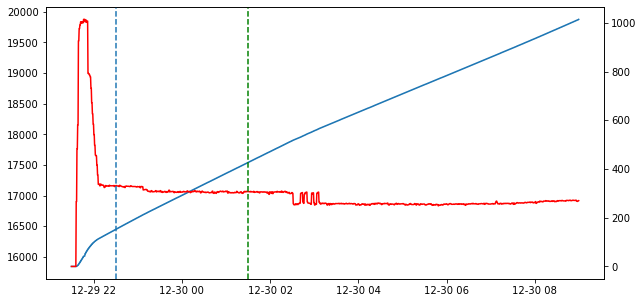

In [9]:
start_day = '2021-12-29 21:30:00'
stop_day = '2021-12-30 9:00:00'

filtered_energy_df = new_energy_df[(new_energy_df['timestamp'] >= start_day) &  (new_energy_df['timestamp'] <= stop_day)]
filtered_energy_df = filtered_energy_df[['energy','power']].resample('30S').mean()

saturation_timestamp = pd.to_datetime(start_day) + pd.to_timedelta(1, 'H')
trigger_timestamp = pd.to_datetime(start_day) + pd.to_timedelta(4, 'H')

plt.figure(1, [10,5])
plt.plot(filtered_energy_df['energy'])
plt.twinx()
plt.plot(filtered_energy_df['power'], 'r')
plt.axvline(x = saturation_timestamp, linestyle='--')
plt.axvline(x = trigger_timestamp, linestyle='--', color='g')

In [10]:
saturation_timestamp = pd.to_datetime(start_day) + pd.to_timedelta(1, 'H')
saturation_energy = filtered_energy_df[filtered_energy_df.index >= start_day].iloc[0]['energy']
trigger_timestamp = pd.to_datetime(start_day) + pd.to_timedelta(4, 'H')
trigger_energy = filtered_energy_df[filtered_energy_df.index >= trigger_timestamp].iloc[0]['energy']

rate_of_change = (trigger_energy - saturation_energy) / (trigger_timestamp - saturation_timestamp).total_seconds()
the_rest_of_time = (pd.to_datetime(stop_day) - trigger_timestamp).total_seconds()

estimated_energy = rate_of_change * the_rest_of_time + trigger_energy
energy_at_start = filtered_energy_df['energy'].iloc[0]
energy_at_stop = filtered_energy_df['energy'].iloc[-1]

print(f'Saturated Temperature Energy {saturation_energy} at {saturation_timestamp}')
print(f'Trigger Energy {trigger_energy} at {trigger_timestamp}')

print(f'estimated energy: {estimated_energy}')
print(f'real energy: {energy_at_stop}')

error = estimated_energy - energy_at_stop
print(f'Error: {error}')

percentage_diff = (error / (energy_at_stop - energy_at_start)) * 100
print(f'Percentage different: {percentage_diff}%')

Saturated Temperature Energy 15843.0 at 2021-12-29 22:30:00
Trigger Energy 17538.0 at 2021-12-30 01:30:00
estimated energy: 21775.5
real energy: 19877.0
Error: 1898.5
Percentage different: 47.06246901338621%


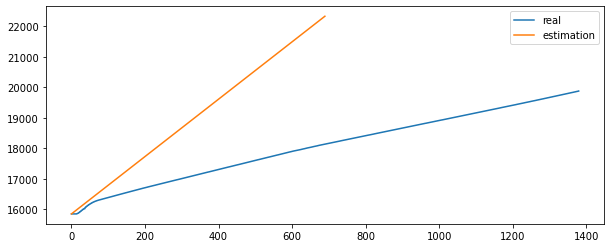

In [11]:
srate = 60
total_time = (pd.to_datetime(stop_day) - pd.to_datetime(start_day)).total_seconds()

x = np.arange(0,total_time, srate)
estimated_energy_line = rate_of_change * x + filtered_energy_df['energy'].iloc[0]
estimated_energy_line.shape[0]

plt.figure(1,[10,4])
plt.plot(filtered_energy_df['energy'].to_numpy(), label='real')
plt.plot(estimated_energy_line, label='estimation')
plt.legend()